## Packages

In [1]:
!git clone https://github.com/openai/multiagent-particle-envs && cd multiagent-particle-envs/

Cloning into 'multiagent-particle-envs'...
remote: Enumerating objects: 281, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 281 (delta 25), reused 26 (delta 15), pack-reused 237
Receiving objects: 100% (281/281), 114.38 KiB | 4.77 MiB/s, done.
Resolving deltas: 100% (152/152), done.


In [2]:
%cd multiagent-particle-envs/

/content/multiagent-particle-envs


In [3]:
!pip install -e .

Obtaining file:///content/multiagent-particle-envs
  Preparing metadata (setup.py) ... done
  Running setup.py develop for multiagent


In [4]:
!pip install gym==0.10.5
!pip install pyglet==1.3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 853.1/853.1 kB 23.1 MB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.10.5-py3-none-any.whl size=1581280 sha256=f8b983baca057b5d7cecb15041a47112df297ff6b60a986362a91305686804dd
  Stored in directory: /root/.cache/pip/wheels/f6/e4/3b/b3b32d8cdedd0e70545cc0a9139f3d66f8fd5d0c95d828d38e
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.7 MB/s eta 0:00:00
  Attempting uninstall: pyglet
    Found existing installation: pyglet 2.0.8
    Uninstalling pyglet-2.0.8:
      Successfully uninstalled pyglet-2.0.8


## Libraries

In [5]:
import random
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np
import threading
import matplotlib.pyplot as plt
import inspect
import functools

## Args

In [33]:
class Args:
  def __init__(self):
    pass

## Environment

In [32]:
def make_env(args):
    from multiagent.environment import MultiAgentEnv
    import multiagent.scenarios as scenarios

    # load scenario from script
    scenario = scenarios.load(args.scenario_name + ".py").Scenario()

    # create world
    world = scenario.make_world()
    # create multiagent environment
    env = MultiAgentEnv(world, scenario.reset_world, scenario.reward, scenario.observation)
    args.n_players = env.n
    args.n_agents = env.n - args.num_adversaries
    args.obs_shape = [env.observation_space[i].shape[0] for i in range(args.n_agents)]
    action_shape = []
    for content in env.action_space:
        action_shape.append(content.n)
    args.action_shape = action_shape[:args.n_agents]
    args.high_action = 1
    args.low_action = -1
    return env, args

## Replay Buffer

In [34]:
class Buffer:
    def __init__(self, args):
        self.size = args.buffer_size
        self.args = args
        # memory management
        self.current_size = 0
        # create the buffer to store info
        self.buffer = dict()
        for i in range(self.args.n_agents):
            self.buffer['o_%d' % i] = np.empty([self.size, self.args.obs_shape[i]])
            self.buffer['u_%d' % i] = np.empty([self.size, self.args.action_shape[i]])
            self.buffer['r_%d' % i] = np.empty([self.size])
            self.buffer['o_next_%d' % i] = np.empty([self.size, self.args.obs_shape[i]])
        # thread lock
        self.lock = threading.Lock()

    # store the episode
    def store_episode(self, o, u, r, o_next):
        idxs = self._get_storage_idx(inc=1)
        for i in range(self.args.n_agents):
            with self.lock:
                self.buffer['o_%d' % i][idxs] = o[i]
                self.buffer['u_%d' % i][idxs] = u[i]
                self.buffer['r_%d' % i][idxs] = r[i]
                self.buffer['o_next_%d' % i][idxs] = o_next[i]

    # sample the data from the replay buffer
    def sample(self, batch_size):
        temp_buffer = {}
        idx = np.random.randint(0, self.current_size, batch_size)
        for key in self.buffer.keys():
            temp_buffer[key] = self.buffer[key][idx]
        return temp_buffer

    def _get_storage_idx(self, inc=None):
        inc = inc or 1
        if self.current_size+inc <= self.size:
            idx = np.arange(self.current_size, self.current_size+inc)
        elif self.current_size < self.size:
            overflow = inc - (self.size - self.current_size)
            idx_a = np.arange(self.current_size, self.size)
            idx_b = np.random.randint(0, self.current_size, overflow)
            idx = np.concatenate([idx_a, idx_b])
        else:
            idx = np.random.randint(0, self.size, inc)
        self.current_size = min(self.size, self.current_size+inc)
        if inc == 1:
            idx = idx[0]
        return idx

## Actor & Critic

In [35]:
# define the actor network
class Actor(nn.Module):
    def __init__(self, args, agent_id):
        super(Actor, self).__init__()
        self.max_action = args.high_action
        self.fc1 = nn.Linear(args.obs_shape[agent_id], 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.action_out = nn.Linear(64, args.action_shape[agent_id])

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        actions = self.max_action * torch.tanh(self.action_out(x))

        return actions


class Critic(nn.Module):
    def __init__(self, args):
        super(Critic, self).__init__()
        self.max_action = args.high_action
        self.fc1 = nn.Linear(sum(args.obs_shape) + sum(args.action_shape), 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.q_out = nn.Linear(64, 1)

    def forward(self, state, action):
        state = torch.cat(state, dim=1)
        for i in range(len(action)):
            action[i] /= self.max_action
        action = torch.cat(action, dim=1)
        x = torch.cat([state, action], dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        q_value = self.q_out(x)
        return q_value

## M3DDPG

In [50]:
class M3DDPG:
    def __init__(self, args, agent_id):
        self.args = args
        self.agent_id = agent_id
        self.train_step = 0

        # create the network
        self.actor_network = Actor(args, agent_id)
        self.critic_network = Critic(args)

        # build up the target network
        self.actor_target_network = Actor(args, agent_id)
        self.critic_target_network = Critic(args)

        # load the weights into the target networks
        self.actor_target_network.load_state_dict(self.actor_network.state_dict())
        self.critic_target_network.load_state_dict(self.critic_network.state_dict())

        # create the optimizer
        self.actor_optim = torch.optim.Adam(self.actor_network.parameters(), lr=self.args.lr_actor)
        self.critic_optim = torch.optim.Adam(self.critic_network.parameters(), lr=self.args.lr_critic)

    def select_action(self, o, noise_rate):
        inputs = torch.tensor(o, dtype=torch.float32).unsqueeze(0)
        pi = self.actor_network(inputs).squeeze(0)
        u = pi.cpu().numpy()
        noise = noise_rate * self.args.high_action * np.random.randn(*u.shape)  # gaussian noise
        u += noise
        u = np.clip(u, -self.args.high_action, self.args.high_action)
        return u

    # soft update
    def _soft_update_target_network(self):
        for target_param, param in zip(self.actor_target_network.parameters(), self.actor_network.parameters()):
            target_param.data.copy_((1 - self.args.tau) * target_param.data + self.args.tau * param.data)

        for target_param, param in zip(self.critic_target_network.parameters(), self.critic_network.parameters()):
            target_param.data.copy_((1 - self.args.tau) * target_param.data + self.args.tau * param.data)

    # update the network
    def train(self, transitions, other_agents):
        for key in transitions.keys():
            transitions[key] = torch.tensor(transitions[key], dtype=torch.float32)
        r = transitions['r_%d' % self.agent_id]
        o, u, o_next = [], [], []
        for agent_id in range(self.args.n_agents):
            o.append(transitions['o_%d' % agent_id])
            u.append(transitions['u_%d' % agent_id])
            o_next.append(transitions['o_next_%d' % agent_id])

        # calculate the target Q value function
        _u_next = []
        u_next = []
        with torch.no_grad():
            index = 0
            for agent_id in range(self.args.n_agents):
                if agent_id == self.agent_id:
                    _u_next.append(self.actor_target_network(o_next[agent_id]))
                else:
                    _u_next.append(other_agents[index].policy.actor_target_network(o_next[agent_id]))
                    index += 1
            q_next = self.critic_target_network(o_next, _u_next).detach()

            target_q = (r.unsqueeze(1) + self.args.gamma * q_next).detach()

            index = 0
            for agent_id in range(self.args.n_agents):
                if agent_id == self.agent_id:
                    u_next.append(self.actor_target_network(o_next[agent_id]))
                else:
                    u_star = other_agents[index].policy.actor_target_network(o_next[agent_id])
                    u_star += self.args.alpha * (target_q - self.critic_network(o, u)).pow(2).mean()
                    u_next.append(u_star)
                    index += 1
            q_next = self.critic_target_network(o_next, u_next).detach()

            target_q = (r.unsqueeze(1) + self.args.gamma * q_next).detach()

        # the q loss
        q_value = self.critic_network(o, u)
        critic_loss = (target_q - q_value).pow(2).mean()

        # the actor loss
        u[self.agent_id] = self.actor_network(o[self.agent_id])
        actor_loss = - self.critic_network(o, u).mean()

        # update the network
        self.actor_optim.zero_grad()
        actor_loss.backward()
        self.actor_optim.step()
        self.critic_optim.zero_grad()
        critic_loss.backward()
        self.critic_optim.step()

        self._soft_update_target_network()
        self.train_step += 1

## Agent

In [37]:
class Agent:
    def __init__(self, agent_id, args):
        self.args = args
        self.agent_id = agent_id
        self.policy = MADDPG(args, agent_id)

    def select_action(self, o, noise_rate, epsilon):
        if np.random.uniform() < epsilon:
            u = np.random.uniform(-self.args.high_action, self.args.high_action, self.args.action_shape[self.agent_id])
        else:
            u = self.policy.select_action(o, noise_rate)
        return u.copy()

    def learn(self, transitions, other_agents):
        self.policy.train(transitions, other_agents)


## Runner

In [38]:
class Runner:
    def __init__(self, args, env):
        self.args = args
        self.noise = args.noise_rate
        self.epsilon = args.epsilon
        self.episode_limit = args.max_episode_len
        self.env = env
        self.agents = self._init_agents()
        self.buffer = Buffer(args)

    def _init_agents(self):
        agents = []
        for i in range(self.args.n_agents):
            agent = Agent(i, self.args)
            agents.append(agent)
        return agents

    def run(self):
        returns = []
        for time_step in tqdm(range(self.args.time_steps)):
            # reset the environment
            if time_step % self.episode_limit == 0:
                s = self.env.reset()
            u = []
            actions = []
            with torch.no_grad():
                for agent_id, agent in enumerate(self.agents):
                    action = agent.select_action(s[agent_id], self.noise, self.epsilon)
                    u.append(action)
                    actions.append(action)
            for i in range(self.args.n_agents, self.args.n_players):
                actions.append([0, np.random.rand() * 2 - 1, 0, np.random.rand() * 2 - 1, 0])
            s_next, r, done, info = self.env.step(actions)
            self.buffer.store_episode(s[:self.args.n_agents], u, r[:self.args.n_agents], s_next[:self.args.n_agents])
            s = s_next
            if self.buffer.current_size >= self.args.batch_size:
                transitions = self.buffer.sample(self.args.batch_size)
                for agent in self.agents:
                    other_agents = self.agents.copy()
                    other_agents.remove(agent)
                    agent.learn(transitions, other_agents)
            if time_step > 0 and time_step % self.args.evaluate_rate == 0:
                returns.append(self.evaluate())
            self.noise = max(0.05, self.noise - 0.0000005)
            self.epsilon = max(0.05, self.epsilon - 0.0000005)
        return returns

    def evaluate(self):
        returns = []
        for episode in range(self.args.evaluate_episodes):
            # reset the environment
            s = self.env.reset()
            rewards = 0
            for time_step in range(self.args.evaluate_episode_len):
                actions = []
                with torch.no_grad():
                    for agent_id, agent in enumerate(self.agents):
                        action = agent.select_action(s[agent_id], 0, 0)
                        actions.append(action)
                for i in range(self.args.n_agents, self.args.n_players):
                    actions.append([0, np.random.rand() * 2 - 1, 0, np.random.rand() * 2 - 1, 0])
                s_next, r, done, info = self.env.step(actions)
                rewards += r[0]
                s = s_next
            returns.append(rewards)
            # print('Returns is', rewards)
        return sum(returns) / self.args.evaluate_episodes

## Main Code

In [69]:
args = Args()
args.scenario_name="simple_tag"
args.noise_rate = 0.1
args.epsilon = 0.1
args.max_episode_len = 100
args.lr_actor = 0.0001
args.lr_critic = 0.001
args.buffer_size = int(5e5)
args.evaluate_episodes = 10
args.evaluate_episode_len = 100
args.time_steps = 10000
args.batch_size = 256
args.evaluate_rate = 100
args.gamma = 0.95
args.tau = 0.01
args.alpha = 0.1
args.save_rate = 2000
args.num_adversaries = 1

In [70]:
env, args = make_env(args)
runner = Runner(args, env)
returns = runner.run()

  2%|▏         | 231/10000 [00:03<03:21, 48.45it/s]<ipython-input-50-e35664d7364b>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transitions[key] = torch.tensor(transitions[key], dtype=torch.float32)
100%|██████████| 10000/10000 [08:39<00:00, 19.25it/s]


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


50


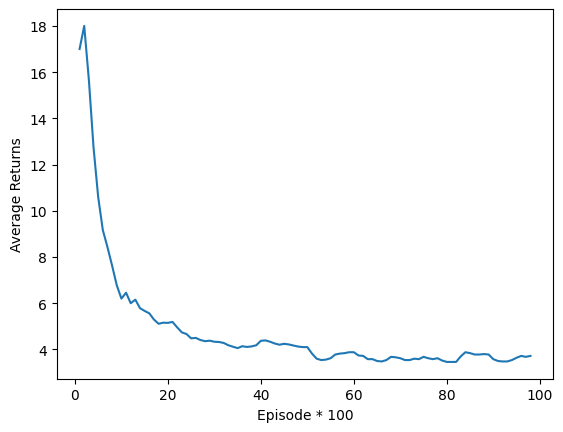

In [71]:
smoothed_returns = []
window_size = int((args.time_steps/args.evaluate_rate)/2)
print(window_size)
for i in range(len(returns)):
  smoothed_returns.append(np.mean(returns[max(0,i-window_size):i]))
plt.plot(smoothed_returns)
plt.ylabel("Average Returns")
plt.xlabel("Episode * 100")
plt.savefig("fig.jpg")